In [1]:
from jax import random, grad
from jax import numpy as np

import pandas as pd
import numpy as onp
from jax.ops import segment_sum

def softmax(utilities):
    exp_utility = np.exp(utilities)
    sum_expu_across_submodels = np.sum(exp_utility, axis=1, keepdims=True)
    proba = exp_utility / sum_expu_across_submodels
    return proba

def mse(target, predicted):
    error = target - predicted
    squared_error = error**2
    return np.mean(squared_error)

# mock data

In [2]:
target = onp.load('target.npy')
x = onp.load('x.npy')
w = np.array([[ 0.00304216,  0.01455319, -0.0026763 ,  0.02046709,
               0.00563778, -0.00192821, -0.01059241,  0.00204556,
               0.0079378 ,  0.00027923,  0.01584745]])

# loss func with probabilities vs loss func w/ discrete sampling

In [3]:
def loss(w):
    logits = np.dot(w, x)
    probas = softmax(logits)
    probas = probas.flatten()
    return mse(probas, target)

key = random.PRNGKey(0)
location_idx = np.arange(x.shape[1])

def loss_discrete_sampling(w):
    logits = np.dot(w, x)
    probas = softmax(logits)
    probas = probas.flatten()
    
    chosen_idx = random.choice(key, location_idx, shape=(1000,), p=probas)
    idx, counts = np.unique(chosen_idx, return_counts=True)
    full_counts = np.zeros(len(location_idx))
    full_counts = full_counts.at[idx].set(counts)
    simulated_alt_shares = full_counts / np.sum(full_counts)
    return mse(simulated_alt_shares, target)

In [4]:
loss(w)

DeviceArray(3.084594e-05, dtype=float32)

In [5]:
loss_discrete_sampling(w)

DeviceArray(3.8901464e-05, dtype=float32)

In [6]:
grad_loss = grad(loss)

In [7]:
grad_loss_discrete = grad(loss_discrete_sampling)

In [8]:
grad_loss(w)

DeviceArray([[-1.22044594e-05, -8.78908122e-06, -1.63980239e-05,
               1.13575879e-05,  9.16346926e-06,  6.60328942e-06,
              -1.83041120e-05,  1.22382235e-05,  1.60980744e-05,
              -2.34838353e-05, -1.55789985e-05]], dtype=float32)

In [9]:
grad_loss_discrete(w)  ### discrete sampling is not differentiable.  all zeros!

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# pseudo-discrete sampling with gumbel-softmax / concrete

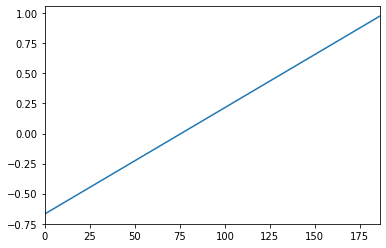

In [10]:
%matplotlib inline
logits2 = np.linspace(-0.66850, 0.974832, x.shape[1])
pd.Series(logits2).plot()

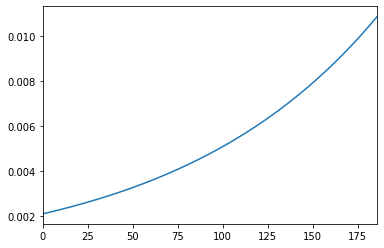

In [11]:
logits2 = logits2.reshape((1, x.shape[1]))

probas2 = softmax(logits2)
pd.Series(probas2[0]).plot()

In [12]:
samples = []
for i in range(1000):
    key = random.PRNGKey(i)
    gumbel_softmax_sample = logits2 + random.gumbel(key, logits2.shape)
    temperature = 0.2
    y = softmax(gumbel_softmax_sample / temperature)
    samples.append(y[0])

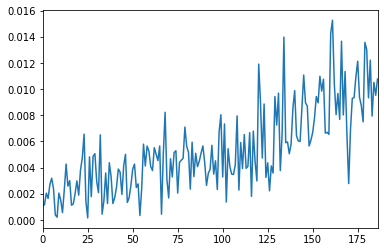

In [13]:
summed_probas = np.vstack(samples).sum(axis=0)

renormalized_summed_probas = summed_probas / np.sum(summed_probas)
pd.Series(renormalized_summed_probas).plot()

In [14]:
onp.corrcoef(probas2[0], renormalized_summed_probas)

array([[1.        , 0.77222847],
       [0.77222847, 1.        ]])

In [15]:
chosen_idx = random.choice(key, location_idx, shape=(1000,), p=probas2[0])
idx, counts = np.unique(chosen_idx, return_counts=True)
full_counts = np.zeros(len(location_idx))
full_counts = full_counts.at[idx].set(counts)
simulated_alt_shares = full_counts / np.sum(full_counts)

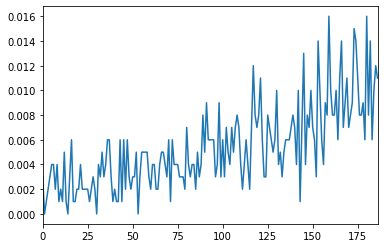

In [16]:
pd.Series(simulated_alt_shares).plot()

In [17]:
onp.corrcoef(probas2[0], simulated_alt_shares)

array([[1.        , 0.74072625],
       [0.74072625, 1.        ]])

# can back-prop through gumbel-softmax

In [18]:
key = random.PRNGKey(3)
def loss_pseudo_discrete_sampling(w):
    logits = np.dot(w, x)
    samples = []
    temperature = 0.2
    for i in range(100):
        key = random.PRNGKey(i)
        gumbel_softmax_sample = logits + random.gumbel(key, logits.shape)
        y = softmax(gumbel_softmax_sample / temperature)
        samples.append(y[0])
    summed_probas = np.vstack(samples).sum(axis=0)
    renormalized_summed_probas = summed_probas / np.sum(summed_probas)
    return mse(renormalized_summed_probas, target)
print(loss_pseudo_discrete_sampling(w))
grad_loss_pseudo_discrete_sampling = grad(loss_pseudo_discrete_sampling)
print(grad_loss_pseudo_discrete_sampling(w))

7.5157724e-05
[[-1.2923818e-05 -1.1350648e-05  1.8019664e-05 -1.6327062e-05
   8.9170220e-07 -7.0210199e-06  1.6905227e-05  5.3341109e-06
  -6.8622544e-06 -1.5262291e-05  1.8989214e-05]]


### a couple of next steps:
* instead of looping over choosers (e.g. for i in range(100)), either us vmap, or vstack the logits and then generate matrix of gumbel samples of same shape as the stacked logits.
* Think about how to capacity constrain